In [1]:
import os
import pandas as pd
import numpy as np
import pathlib
import copy
import matplotlib.pyplot as plt
from IPython.display import display_html

from additional_functions import correlation_with_confidence as fcn

README - For those that used the Go implementation

If you used the Go implementation to compute the distributions of correlation coefficients, you can skip to the part where these csvs are loaded. You will have to slightly adjust the input path to point the script towards the directory that actually houses the csvs. Alternativelly, you can create a directory that corresponds to corr_dir = os.path.join(root_dir,'correlation_values') and put the csvs there.

## Example usage
__The code below demonstrates the use of the proposed method on specific data. Modifications will likely be needed your specific use case.__

### Main functions
- __`mos_distributions = fcn.create_mos_distributions(scene_votes, n_iterations,...)`__

    Inputs:
    - `scene_votes` is __either__:
        - `a dictionary`, where keys are scene/stimuli names/indices and values are lists of measured scores

        ```python
        scene_votes = {
            'scene_01': ['vote_01', 'vote_02', 'vote_03'],
            'scene_02': ['vote_01', 'vote_02', 'vote_03']
        }
        ```

        - `a list of lists`, similar to [means, stds, n_votes], where `means`, `stds`, `n_votes` are themselves lists of values

        ```python
        scene_votes = [
            ['mean_01', 'mean_02', 'mean_03'],
            ['std_01', 'std_02', 'std_03'],
            ['n_votes_01', 'n_votes_02', 'n_votes_02']
        ]
        ```

    - `n_iterations` is the number of samples/iterations that the resulting distributions should have

    Output:
    - `mos_distributions` is a `numpy.array` of shape `[num_stimuli, n_iterations]`

    

- __`results = fcn.compute_correlation_distributions(mos_distributions, metric, n_bootstrap, bootstrap_scenes, corr_coeffs)`__

    Inputs:
    - `mos_distributions` is the output of `fcn.create_mos_distributions()`
    - `metric` is a `list` of objective values
    - `n_bootstrap` is the number of bootstraps to use (_should be adjusted based on the required precision and the available computational resources_)
    - `bootstrap_scenes` is a `True`/`False` value that indicates if you want to compute scene bootstrapping or not
    - `corr_coeffs` is a `list` indicating which correlation coefficients to compute (e.g. `['r', 'rho', 'tau']`)

    Output:

    - `results` is a `dictionary` containing lists of results for the specified `corr_coeffs`


In [2]:
root_dir = pathlib.Path('./').absolute()
data_dir = os.path.join(root_dir,'metrics_values')
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

datasets = {'CID2013': {'path': os.path.join(data_dir, 'CID2013.csv'),
                                  'scene_column': 'Source_ID',
                                  'quality_column': 'Image set specific IQ Score with outlier removal'}}

dataset = 'CID2013'

df = pd.read_csv(datasets[dataset]['path'])
quality_column = datasets[dataset]['quality_column']
scene_column = datasets[dataset]['scene_column']

# Ensure 'Y' column is of string type, then convert to lowercase
df[quality_column] = pd.to_numeric(df[quality_column], errors='coerce')

# Drop rows where 'X' is NaN (which were non-numeric values)
df = df.dropna(subset=[quality_column])

df[scene_column] = df[scene_column].astype(str).str.lower()

# Group by scene names and aggregate votes into lists
scene_votes = df.groupby(scene_column)[quality_column].apply(list).to_dict()
scenes = [x.split('/')[-1] for x in list(scene_votes.keys())]
scene_votes = {str(key.split('/')[-1]).lower(): value for key, value in scene_votes.items()}

# backup copy of the MOS info
scene_votes_original = copy.deepcopy(scene_votes)

csv_dir = os.path.join(root_dir,'metrics_values','CID2013_pyiqa_metrics')
allfiles = os.listdir(csv_dir)
files = [ fname for fname in allfiles if fname.endswith('.csv')]

metric_dfs = []

for file in files:
    temp_df = pd.read_csv(os.path.join(csv_dir, file))
    metric_dfs.append(copy.deepcopy(temp_df))

metric_df = metric_dfs[0]

for temp_df in metric_dfs[1:]:
    metric_df = metric_df.merge(temp_df, on=['name'], how='inner')

metrics_df = metric_df.drop(['scores'], axis=1)

metric_df.head()

# metric_df_musiq = pd.read_csv(os.path.join(csv_dir,'CID2013_musiq.csv'))
# metric_df_compare = pd.read_csv(os.path.join(csv_dir,'CID2013_dbcnn.csv'))

,name,brisque,clipiqa+,dbcnn,hyperiqa,maniqa,musiq,niqe,paq2piq,tres,wadiqam_nr,topiq_nr,scores
0,IS_III_C01_D01.jpg,38.305847,0.696838,0.679737,0.576001,0.356848,74.853401,4.132705,78.242287,52.318150,-0.310695,0.697325,"[99.0, 93.0, 99.0, 91.0, 99.0, 100.0, 100.0, 1..."
1,IS_III_C01_D02.jpg,13.233093,0.545229,0.468965,0.387142,0.262530,58.037872,4.941223,73.756340,30.950836,-1.027444,0.406296,"[90.0, 70.0, 87.0, 94.0, 100.0, 68.0, 61.0, 83..."
2,IS_III_C01_D03.jpg,14.511902,0.597398,0.512649,0.425575,0.278617,62.406807,4.435768,73.887917,35.766712,-0.874564,0.449001,"[100.0, 66.0, 91.0, 98.0, 99.0, 65.0, 93.0, 73..."
3,IS_III_C01_D04.jpg,14.288269,0.477034,0.476494,0.380697,0.258746,56.139645,4.359759,72.745316,37.201702,-1.140447,0.404220,"[93.0, 74.0, 43.0, 46.0, 30.0, 37.0, 36.0, 50...."
4,IS_III_C01_D05.jpg,58.015320,0.342469,0.258663,0.324775,0.269806,20.301790,6.883956,50.862602,28.221977,-1.033692,0.265599,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [3]:
scenes = list(scene_votes_original.keys())[3]
scene_votes = {}

for scene in scenes:
    temp_dict = {key: value for key, value in scene_votes_original.items() if scene in key}
    scene_votes = {**scene_votes, **temp_dict}

scene_votes_keys = list(scene_votes.keys())

# scene_votes is a dictionary, where the key is the name of each scene/stimuli and the value is a list of votes

# UNCOMMENT THE CODE BELOW TO USE MOS AND STD INSTEAD OF RAW SCORES
# means = []
# stds = []
# # compute summary statistics from raw scores
# for key in list(scene_votes.keys()):
#     means.append(np.mean(scene_votes[key]))
#     stds.append(np.std(scene_votes[key]))

# # estimate the distributions of means from summary statistics

# # need to supply the number of casted votes to model
# n_votes = len(scene_votes['is_i_c01_d01'])

# scene_votes = [means, stds, n_votes]

### Propagate confidence intervals

The code below shows how to use the prepared scripts, given subjective scores and several objective metrics.

In [4]:
# estimate the distributions of means from raw scores
mos_distributions = fcn.create_mos_distributions(scene_votes=scene_votes, n_iterations=1499)

In [5]:
metrics_names = [m for m in list(metrics_df.keys()) if m not in ['filename', 'name', 'mos', 'std']]

corr_dir = os.path.join(root_dir,'correlation_values')

pearson_distributions = {}
spearman_distributions = {}
kendall_distributions = {}

for metric_name in metrics_names:

    print(f'Computing correlation distributions for {metric_name}')

    names = metric_df['name'].str.replace('.jpg', '', regex=False).str.lower()
    metric = metric_df[metric_name].values
    # Create a dictionary mapping names to values
    name_to_value = dict(zip(names, metric))

    metric = np.array([name_to_value[name] for name in scene_votes_keys])

    # SET bootstrap_scenes = False TO DISABLE SCENE BOOTSTRAPPING
    temp = fcn.compute_correlation_distributions(mos_distributions, metric, n_bootstrap=14999, bootstrap_scenes=True, corr_coeffs=['r', 'rho', 'tau'])
    pearson_distributions[metric_name] = np.abs(temp['r'])
    spearman_distributions[metric_name] = np.abs(temp['rho'])
    kendall_distributions[metric_name] = np.abs(temp['tau'])

corr_coefs = [pearson_distributions, spearman_distributions, kendall_distributions]
corr_name = ['Pearson', 'Spearman', 'Kendall']

Computing correlation distributions for brisque
Computing correlation distributions for clipiqa+
Computing correlation distributions for dbcnn
Computing correlation distributions for hyperiqa
Computing correlation distributions for maniqa
Computing correlation distributions for musiq
Computing correlation distributions for niqe
Computing correlation distributions for paq2piq
Computing correlation distributions for tres
Computing correlation distributions for wadiqam_nr
Computing correlation distributions for topiq_nr


### Save/load the computed outputs as csv

Use the commonly used .csv format to save the output distributions.

In [6]:
save_df = False

if save_df:

    corr_dir = os.path.join(root_dir,'correlation_values')
    if not os.path.isdir(corr_dir):
        os.makedirs(corr_dir)

    temp_df = pd.DataFrame(pearson_distributions)
    temp_df.to_csv(os.path.join(corr_dir,f"{dataset}_pearson.csv"), index=False)

    temp_df = pd.DataFrame(spearman_distributions)
    temp_df.to_csv(os.path.join(corr_dir,f"{dataset}_spearman.csv"), index=False)

    temp_df = pd.DataFrame(kendall_distributions)
    temp_df.to_csv(os.path.join(corr_dir,f"{dataset}_kendall.csv"), index=False)

In [7]:
load_csv = False

if load_csv:

    corr_dir = os.path.join(root_dir,'correlation_values')
    if os.path.isdir(corr_dir):

        temp_df = pd.read_csv(os.path.join(corr_dir,f"{dataset}_pearson.csv"))
        pearson_distributions = temp_df.to_dict(orient='list')

        temp_df = pd.read_csv(os.path.join(corr_dir,f"{dataset}_spearman.csv"))
        spearman_distributions = temp_df.to_dict(orient='list')

        temp_df = pd.read_csv(os.path.join(corr_dir,f"{dataset}_kendall.csv"))
        kendall_distributions = temp_df.to_dict(orient='list')

In [8]:
# Add a new line or any additional HTML content
new_line = "<p></p>"

df_corrs = {}
sorting_orders = []

for idx, input_dict in enumerate(corr_coefs):

    output_dict = {'metric':[], 'mean':[], 'median':[], 'perc_low': [], 'perc_high': []}
    
    for key in input_dict:

            output_dict['metric'].append(key)
            output_dict['mean'].append(np.abs(np.mean(input_dict[key])))
            output_dict['median'].append(np.abs(np.median(input_dict[key])))

            perc_low, perc_high = np.abs(np.percentile(input_dict[key], [2.5, 97.5]))
            output_dict['perc_low'].append(perc_low)
            output_dict['perc_high'].append(perc_high)


    df_corr = pd.DataFrame.from_dict(output_dict)
    sorting_orders.append(np.argsort(-df_corr["mean"].values))
    df_corr = df_corr.sort_values(by=['mean'], ascending=False).reset_index(drop=True)
    df_corrs[corr_name[idx]] = copy.deepcopy(df_corr)

    if idx == 0:
        df_html = f"<p>{corr_name[idx]} correlation</p>"
    else:
        df_html += f"<p>{corr_name[idx]} correlation</p>"

    df_html += df_corr.round(4).head(20).to_html()
    df_html += new_line

# Combine the HTML representations side by side using display_html
display_html(df_html, raw=True)

,metric,mean,median,perc_low,perc_high
0,musiq,0.8178,0.8185,0.7827,0.8507
1,topiq_nr,0.8069,0.8070,0.7756,0.8367
2,maniqa,0.7913,0.7917,0.7546,0.8242
3,dbcnn,0.7865,0.7863,0.7507,0.8202
4,clipiqa+,0.7864,0.7865,0.7503,0.8203
5,hyperiqa,0.7600,0.7608,0.7169,0.7996
6,paq2piq,0.7323,0.7330,0.6867,0.7767
7,tres,0.7007,0.7008,0.6501,0.7509
8,niqe,0.6103,0.6114,0.5527,0.6659
9,wadiqam_nr,0.5927,0.5951,0.5269,0.6533


In [9]:
font_size = 16
axes_size = 18

plt.rc('font', size=font_size)          # controls default text sizes
plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=axes_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=axes_size+2)    # fontsize of the tick labels

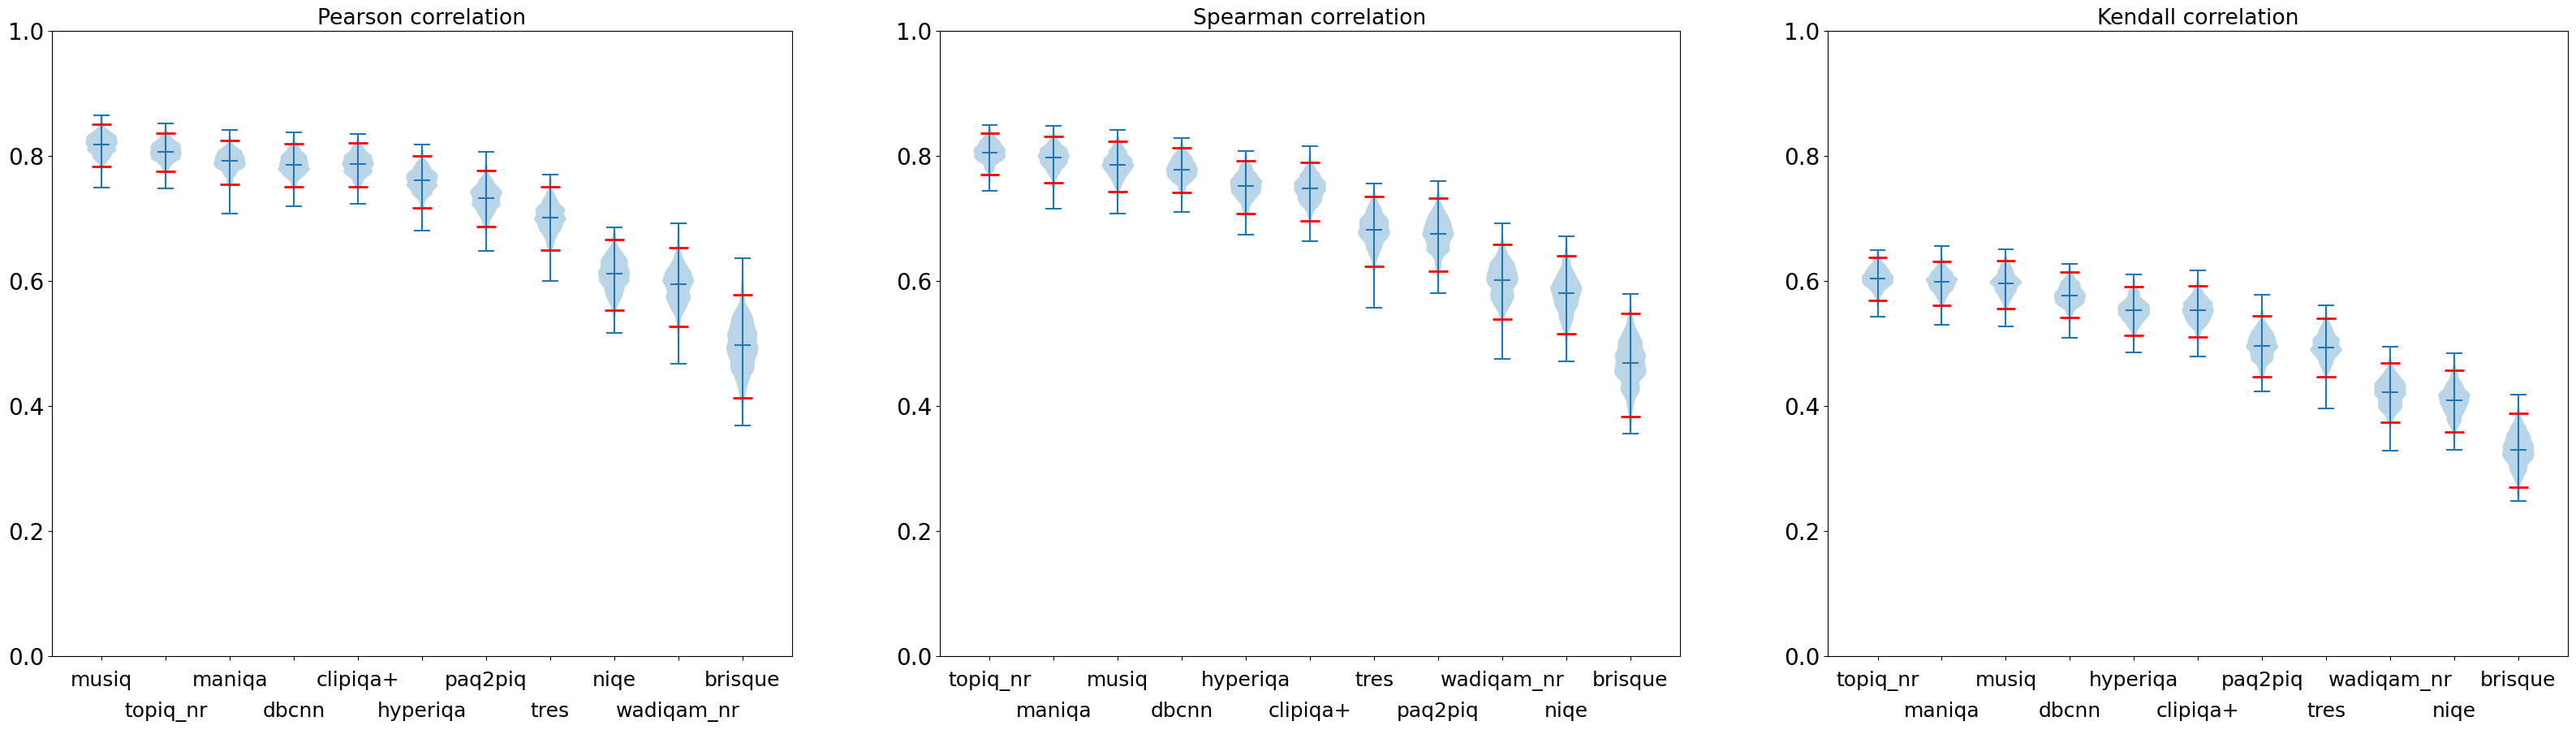

In [10]:
fig, axs = plt.subplots(1,3,figsize=(40, 10))

for idx, input_dict in enumerate(corr_coefs):

    output_dict = {'metric':[], 'mean':[]}
    for key in input_dict:
        output_dict['metric'].append(key)
        output_dict['mean'].append(np.abs(np.mean(input_dict[key])))
    
    df_corr = pd.DataFrame.from_dict(output_dict)
    df_corr = df_corr.sort_values(by=['mean'], ascending=False).reset_index(drop=True)

    labels = list(df_corr['metric'])

    data = [np.abs(input_dict[key]) for key in labels]

    # Calculate the 95% confidence interval for each dataset
    confidence_intervals = []
    for d in data:
        lower_bound = np.percentile(d, 2.5)
        upper_bound = np.percentile(d, 97.5)
        confidence_intervals.append((lower_bound, upper_bound))

    # Create the violin plot
    violins = axs[idx].violinplot(data, showmeans=False, showmedians=True)

    # Add 95% confidence interval lines
    for i, (lower, upper) in enumerate(confidence_intervals):
        axs[idx].hlines([lower, upper], i + 0.85, i + 1.15, color='red', linestyle='-', lw=2)

    # Add x-ticks with the keys of the dictionary
    # axs[idx].xticks(ticks=range(1, len(labels) + 1), labels=labels)
    axs[idx].set_xticks(range(1, len(labels) + 1))  # Set the positions of ticks
    axs[idx].set_xticklabels(labels)  # Set the labels

    for i, label in enumerate(axs[idx].get_xticklabels()):
    # Stagger the labels by adjusting y-position
        label.set_y(label.get_position()[1] - (0.01 if i % 2 == 0 else 0.06))  # Alternate y-offset

    axs[idx].set_ylim(0, 1)
    axs[idx].set_title(f"{corr_name[idx]} correlation")


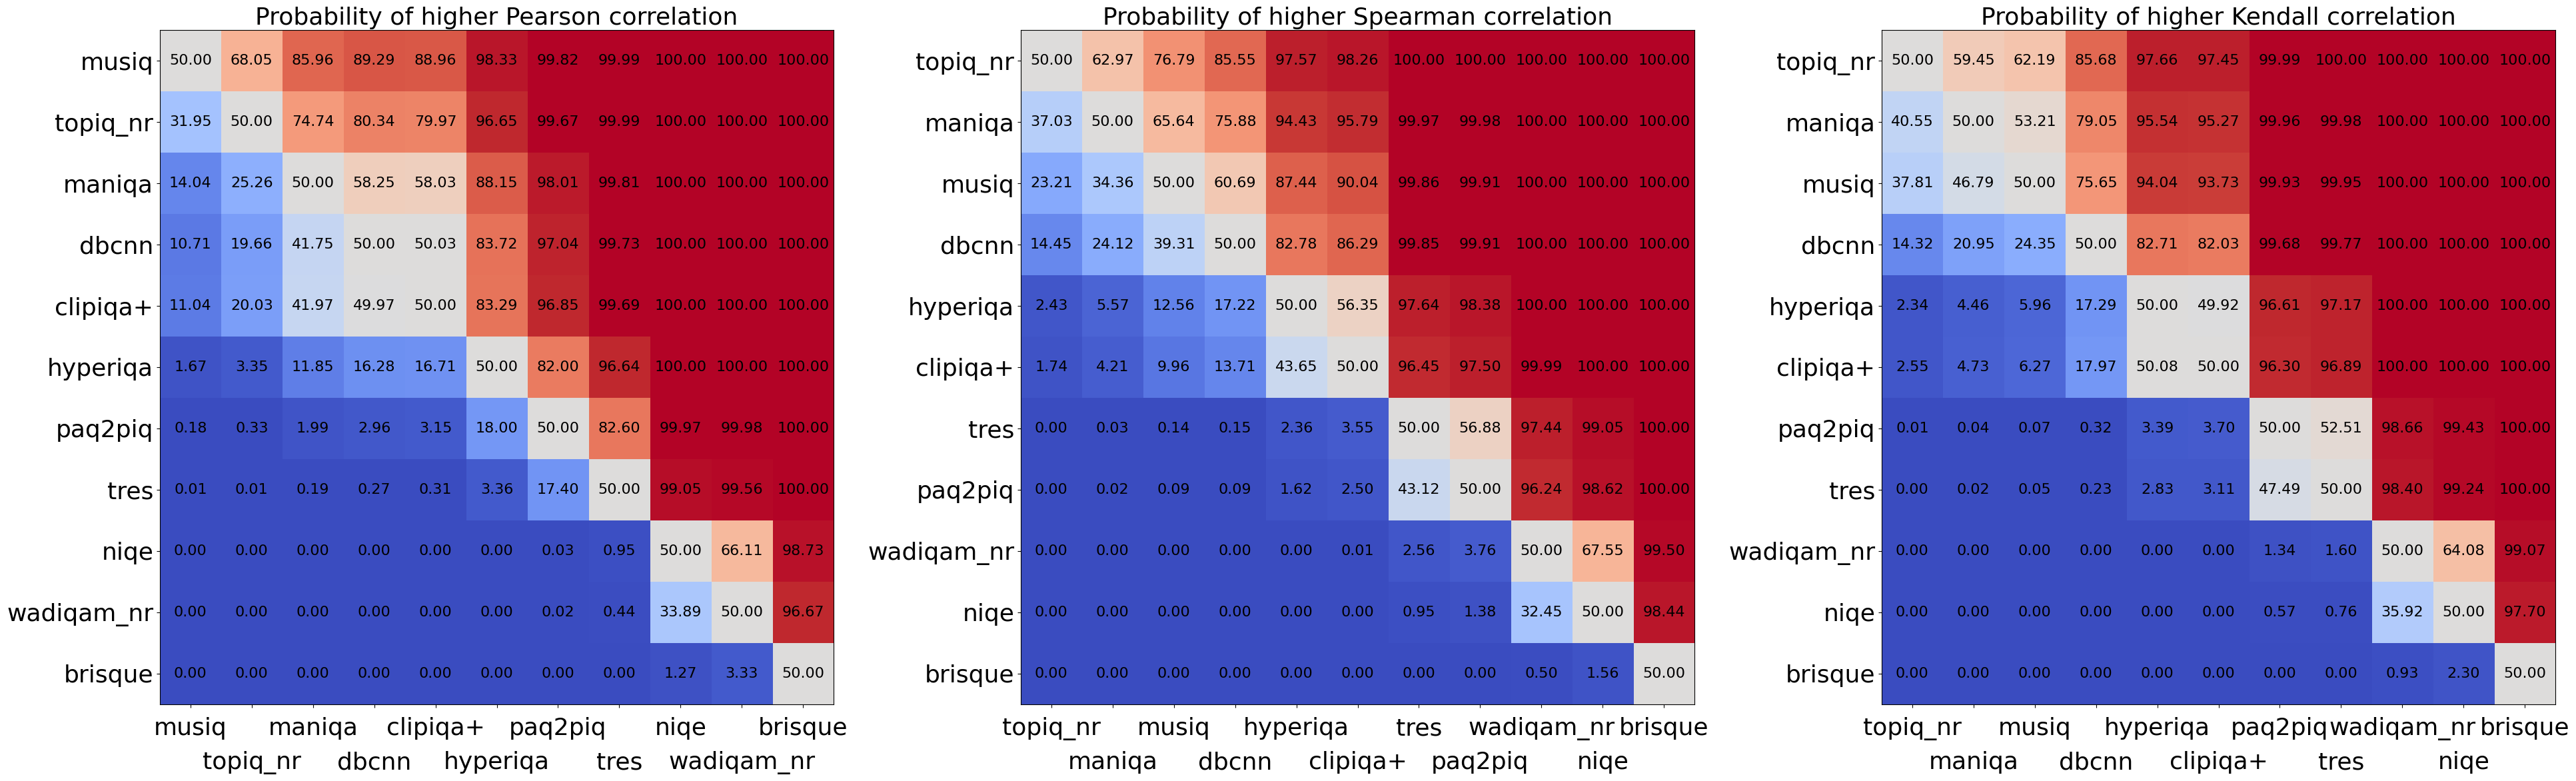

In [11]:
fig2, axs2 = plt.subplots(1,len(corr_coefs),figsize=(39, 13))

for idx, input_dict in enumerate(corr_coefs):


    input_dict_copy = input_dict.copy()
    input_dict_copy.pop('mos_mean', None)
    for key in input_dict_copy:
        input_dict_copy[key] = np.abs(input_dict_copy[key])

    cliffs_delta_matrix = fcn.compute_stats(input_dict_copy)

    win_matrix = ((cliffs_delta_matrix + 1) / 2)*100

    sorted_indices = sorting_orders[idx]

    temp = np.array(metrics_names)

    win_matrix = win_matrix[np.ix_(sorted_indices, sorted_indices)]
    # Plot Cliff's Delta heatmap
    axs2[idx].imshow(win_matrix, cmap='coolwarm', vmin=0, vmax=100)
    axs2[idx].set_xticks(np.arange(len(temp)), labels=list(temp[sorted_indices]), fontsize=26)

    for i, label in enumerate(axs2[idx].get_xticklabels()):
    # Stagger the labels by adjusting y-position
        label.set_y(label.get_position()[1] - (0.01 if i % 2 == 0 else 0.06))  # Alternate y-offset

    axs2[idx].set_yticks(np.arange(len(temp)), labels=list(temp[sorted_indices]), fontsize=26)

    for i in range(len(win_matrix)):
        for j in range(len(win_matrix[i])):
            axs2[idx].text(j, i, f'{win_matrix[i, j]:.2f}', ha='center', va='center', color='black')

    axs2[idx].set_title(f"Probability of higher {corr_name[idx]} correlation", fontsize=26)

fig2.tight_layout()
plt.show()

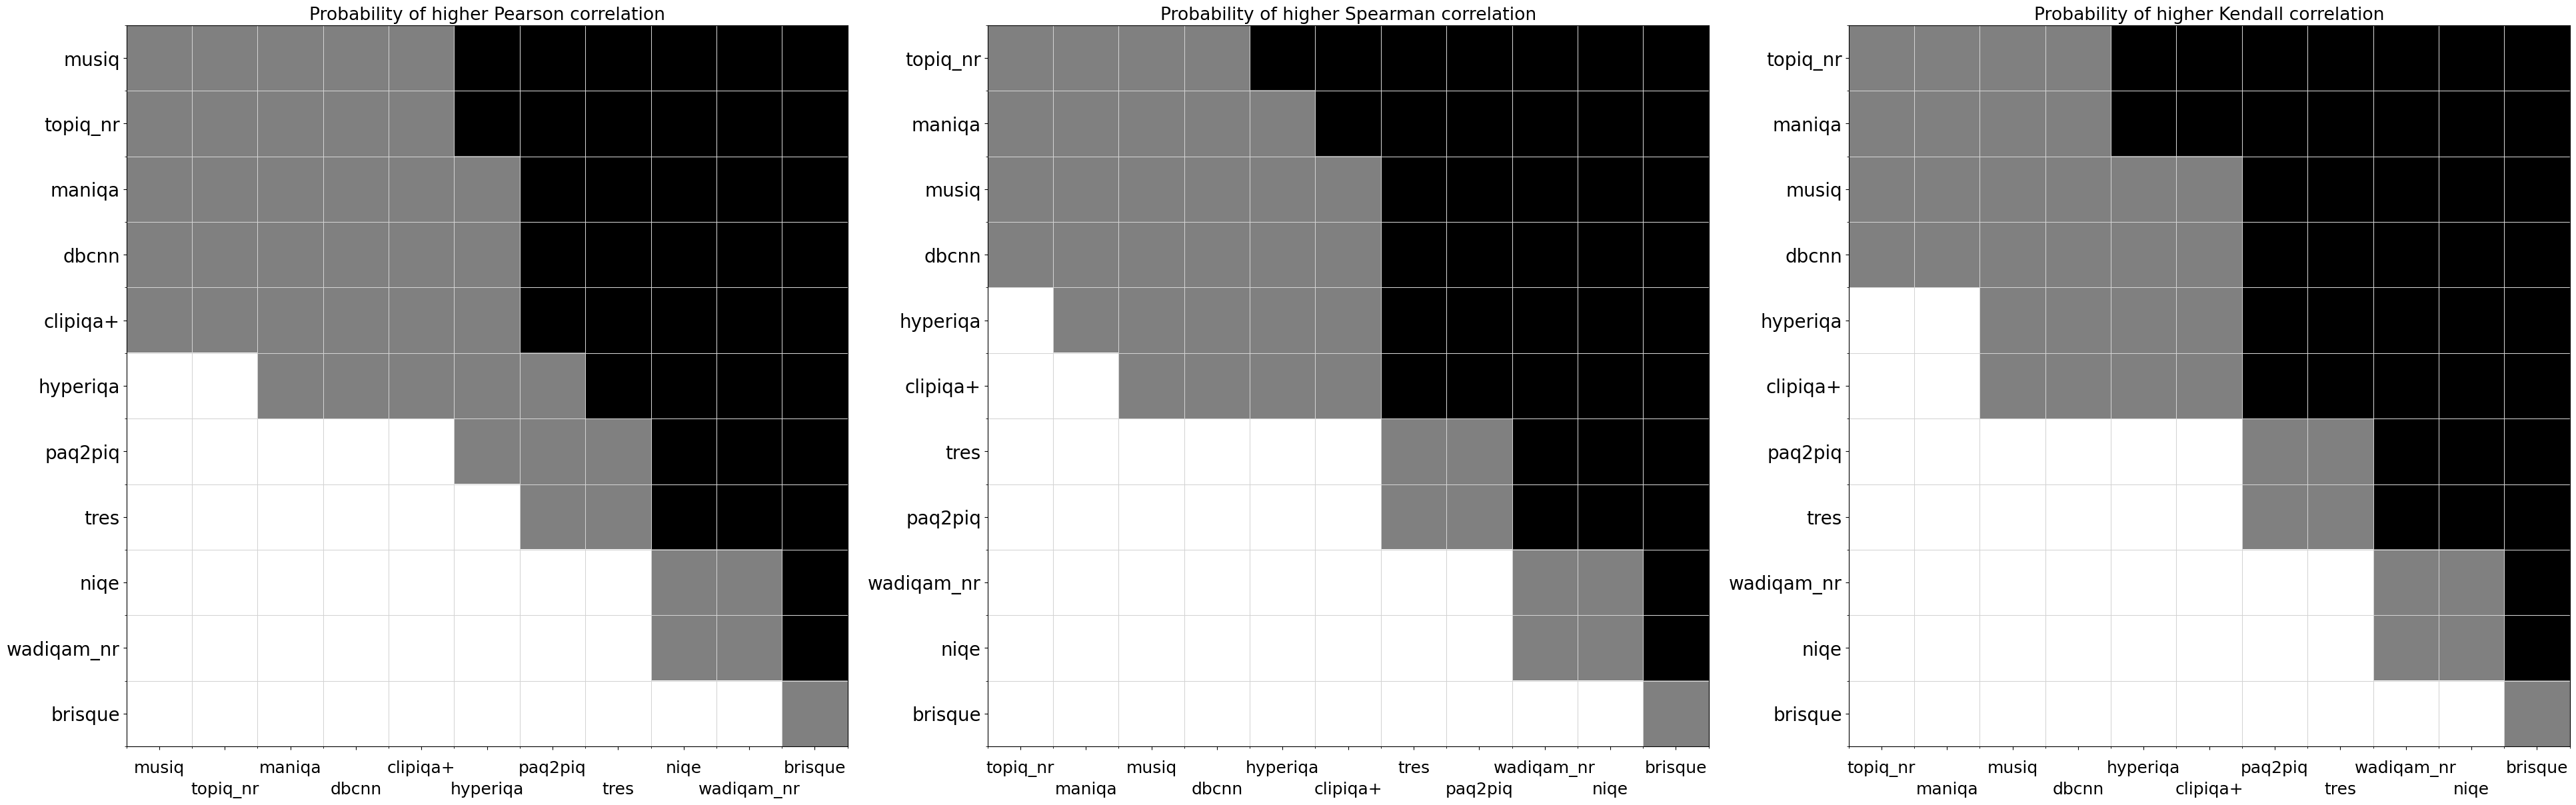

In [12]:
threshold = 95

fig2, axs2 = plt.subplots(1,len(corr_coefs),figsize=(39, 13))

for idx, input_dict in enumerate(corr_coefs):

    input_dict_copy = input_dict.copy()
    input_dict_copy.pop('mos_mean', None)
    for key in input_dict_copy:
        input_dict_copy[key] = np.abs(input_dict_copy[key])

    cliffs_delta_matrix = fcn.compute_stats(input_dict_copy)

    win_matrix = ((cliffs_delta_matrix + 1) / 2)*100

    temp = np.array(metrics_names)

    sorted_indices = sorting_orders[idx]

    win_matrix = win_matrix[np.ix_(sorted_indices, sorted_indices)]

    # Apply thresholding to the data
    threshold_more = win_matrix >= threshold
    threshold_same = (win_matrix < threshold) & (win_matrix > (100-threshold))
    threshold_less = win_matrix <= (100-threshold)

    win_matrix[threshold_more] = 0
    win_matrix[threshold_same] = 0.5
    win_matrix[threshold_less] = 1

    # Plot Cliff's Delta heatmap
    axs2[idx].imshow(win_matrix, cmap='gray', vmin=0, vmax=1)
    axs2[idx].set_xticks(np.arange(len(temp)), labels=list(temp[sorted_indices]))

    for i, label in enumerate(axs2[idx].get_xticklabels()):
    # Stagger the labels by adjusting y-position
        label.set_y(label.get_position()[1] - (0.01 if i % 2 == 0 else 0.04))  # Alternate y-offset

    axs2[idx].set_yticks(np.arange(len(temp)), labels=list(temp[sorted_indices]))

    axs2[idx].set_title(f"Probability of higher {corr_name[idx]} correlation")

    axs2[idx].set_xticks(np.arange(-0.5, win_matrix.shape[1], 1), minor=True)
    axs2[idx].set_yticks(np.arange(-0.5, win_matrix.shape[0], 1), minor=True)
    axs2[idx].grid(which='minor', color='lightgray', linestyle='-', linewidth=0.75)

fig2.tight_layout()
plt.show()